In [1]:
from main import *
from bovw import *
from plotting import *

In [2]:
import os
import random
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

In [4]:
data_train = Dataset(ImageFolder="../data/places_reduced/train")
data_test = Dataset(ImageFolder="../data/places_reduced/val")

len(data_train), len(data_test)

(8700, 2200)

In [5]:
random.shuffle(data_train)
random.shuffle(data_test)

## Histogram Intersection Kernel

The Histogram Intersection Kernel is defined as:

$$K(x, y) = \sum_{i=1}^{n} \min(x_i, y_i)$$

This kernel measures the similarity between two histograms by summing the minimum values at each bin. It's particularly effective for histogram-based features like BOVW.

**Properties:**
- Works well with normalized histograms
- Computationally efficient
- Often outperforms RBF and linear kernels for histogram data
- Values range from 0 (no overlap) to 1 (identical normalized histograms)

In [6]:
# Histogram Intersection Kernel implementation
def histogram_intersection_kernel(X, Y):
    """
    Compute the Histogram Intersection Kernel between X and Y.
    
    K(x, y) = sum_i min(x_i, y_i)
    
    Parameters:
    -----------
    X : array-like, shape (n_samples_X, n_features)
        First set of samples
    Y : array-like, shape (n_samples_Y, n_features)
        Second set of samples
        
    Returns:
    --------
    K : array, shape (n_samples_X, n_samples_Y)
        Kernel matrix
    """
    X = np.atleast_2d(X)
    Y = np.atleast_2d(Y)
    
    # compute row by row to avoid creating a huge 3D array (n_X, n_Y, n_features) and crashing
    n_samples_X = X.shape[0]
    n_samples_Y = Y.shape[0]
    K = np.zeros((n_samples_X, n_samples_Y))
    
    for i in range(n_samples_X):
        K[i] = np.sum(np.minimum(X[i], Y), axis=1)
    
    return K

# Test
print("Testing Histogram Intersection Kernel:")
x = np.array([[0.2, 0.3, 0.5]])
y = np.array([[0.1, 0.4, 0.5]])
K = histogram_intersection_kernel(x, y)
print(f"K(x, y) = {K[0, 0]:.4f}")
print(f"Expected: min(0.2,0.1) + min(0.3,0.4) + min(0.5,0.5) = 0.1 + 0.3 + 0.5 = 0.9")

Testing Histogram Intersection Kernel:
K(x, y) = 0.9000
Expected: min(0.2,0.1) + min(0.3,0.4) + min(0.5,0.5) = 0.1 + 0.3 + 0.5 = 0.9


In [7]:
# Experiment: Histogram Intersection Kernel with different C values
hik_c_results = {}

bovw_params = {
    "detector_type": "SIFT",
    "codebook_size": 512,
    "detector_kwargs": {"nfeatures": 1000},
}

print("=" * 60)
print("HISTOGRAM INTERSECTION KERNEL + C VALUES")
print("=" * 60)

for C in [0.01, 0.1, 1.0, 10.0, 100.0]:
    print(f"\n=== Testing HIK with C={C} ===")
    
    classifier_cls = SVC
    classifier_params = {
        "kernel": histogram_intersection_kernel,
        "C": C,
        "class_weight": "balanced",
        "random_state": SEED,
    }
    
    scores = cross_validate_bovw(
        dataset=data_train,
        bovw_kwargs=bovw_params,
        classifier_cls=classifier_cls,
        classifier_kwargs=classifier_params,
        n_splits=5
    )
    
    hik_c_results[C] = scores
    print(f"C={C} -> Test Accuracy: {scores.val.accuracy.mean:.4f} ± {scores.val.accuracy.std:.4f}")


print("\n" + "=" * 60)
print("HISTOGRAM INTERSECTION KERNEL: C COMPARISON")
print("=" * 60)
for C, result in hik_c_results.items():
    print(f"C={C:6.2f} -> Train: {result.train.accuracy.mean:.4f} ± {result.train.accuracy.std:.4f} | Test: {result.val.accuracy.mean:.4f} ± {result.val.accuracy.std:.4f}")

HISTOGRAM INTERSECTION KERNEL + C VALUES

=== Testing HIK with C=0.01 ===


Phase [Setup]: Extracting the descriptors:  49%|████▉     | 4267/8700 [00:01<00:01, 2333.63it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors: 100%|██████████| 8700/8700 [00:03<00:00, 2323.75it/s]


Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


100%|██████████| 5/5 [05:19<00:00, 63.88s/it]


C=0.01 -> Test Accuracy: 0.3104 ± 0.0117

=== Testing HIK with C=0.1 ===


Phase [Setup]: Extracting the descriptors:  50%|█████     | 4384/8700 [00:01<00:01, 2678.49it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors: 100%|██████████| 8700/8700 [00:03<00:00, 2655.82it/s]


Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


100%|██████████| 5/5 [05:12<00:00, 62.57s/it]


C=0.1 -> Test Accuracy: 0.3311 ± 0.0100

=== Testing HIK with C=1.0 ===


Phase [Setup]: Extracting the descriptors:  50%|█████     | 4366/8700 [00:01<00:01, 2726.77it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors: 100%|██████████| 8700/8700 [00:03<00:00, 2675.03it/s]


Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


100%|██████████| 5/5 [05:22<00:00, 64.43s/it]


C=1.0 -> Test Accuracy: 0.2797 ± 0.0113

=== Testing HIK with C=10.0 ===


Phase [Setup]: Extracting the descriptors:  50%|█████     | 4362/8700 [00:01<00:01, 2723.58it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors: 100%|██████████| 8700/8700 [00:03<00:00, 2653.96it/s]


Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


100%|██████████| 5/5 [05:17<00:00, 63.52s/it]


C=10.0 -> Test Accuracy: 0.2735 ± 0.0071

=== Testing HIK with C=100.0 ===


Phase [Setup]: Extracting the descriptors:  50%|█████     | 4379/8700 [00:01<00:01, 2714.05it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors: 100%|██████████| 8700/8700 [00:03<00:00, 2680.14it/s]


Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


100%|██████████| 5/5 [05:17<00:00, 63.52s/it]

C=100.0 -> Test Accuracy: 0.2804 ± 0.0115

HISTOGRAM INTERSECTION KERNEL: C COMPARISON
C=  0.01 -> Train: 0.3610 ± 0.0032 | Test: 0.3104 ± 0.0117
C=  0.10 -> Train: 0.6549 ± 0.0043 | Test: 0.3311 ± 0.0100
C=  1.00 -> Train: 0.9961 ± 0.0008 | Test: 0.2797 ± 0.0113
C= 10.00 -> Train: 1.0000 ± 0.0000 | Test: 0.2735 ± 0.0071
C=100.00 -> Train: 1.0000 ± 0.0000 | Test: 0.2804 ± 0.0115


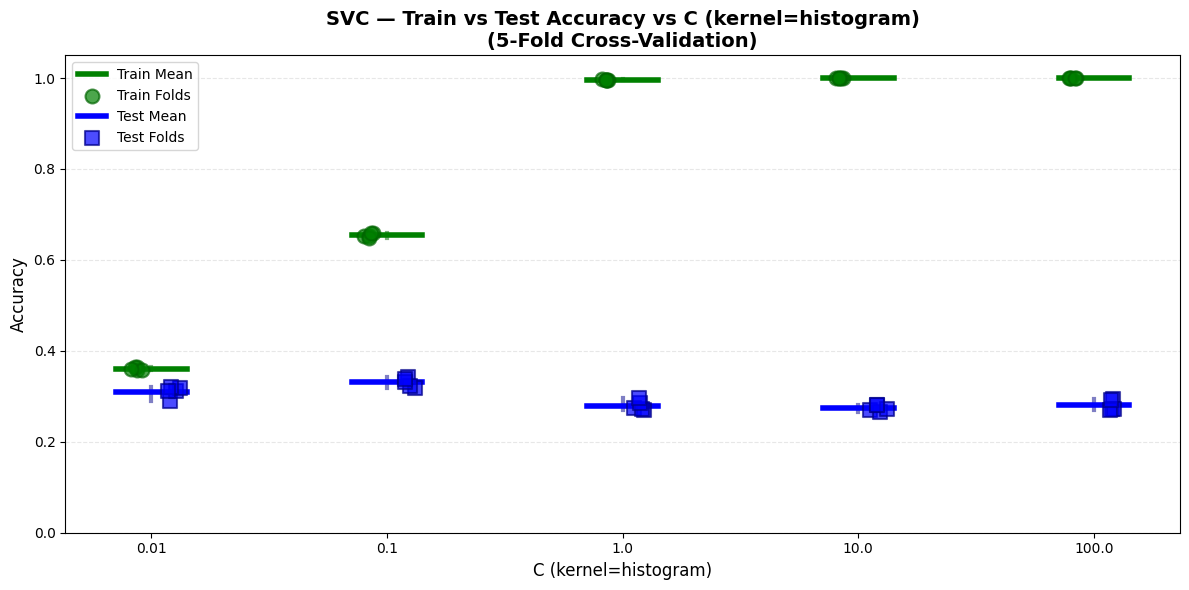

In [10]:
x_vals = [0.01, 0.1, 1.0, 10.0, 100.0]
printable_x_vals = [0.01, 0.1, 1.0, 10.0, 100.0]
test_vals = [hik_c_results[key].val.accuracy.all for key in x_vals]
train_vals = [hik_c_results[key].train.accuracy.all for key in x_vals]
plot_cv_train_test_comparison(printable_x_vals, train_vals, test_vals, "SVC", f"C (kernel=histogram)", ylim=(0.0, 1.05))

In [12]:
# Compare HIK with standard kernels (at C=1.0)
print("=" * 60)
print("KERNEL COMPARISON (C=1.0)")
print("=" * 60)

comparison_results = {}

# Test Linear kernel
print("\n=== Testing Linear Kernel ===")
scores = cross_validate_bovw(
    dataset=data_train,
    bovw_kwargs=bovw_params,
    classifier_cls=SVC,
    classifier_kwargs={
        "kernel": "linear",
        "C": 1.0,
        "class_weight": "balanced",
        "random_state": SEED,
    },
    n_splits=5
)
comparison_results["linear"] = scores
print(f"Linear -> Test Accuracy: {scores.val.accuracy.mean:.4f} ± {scores.val.accuracy.std:.4f}")

# Test RBF kernel
print("\n=== Testing RBF Kernel ===")
scores = cross_validate_bovw(
    dataset=data_train,
    bovw_kwargs=bovw_params,
    classifier_cls=SVC,
    classifier_kwargs={
        "kernel": "rbf",
        "C": 1.0,
        "gamma": "scale",
        "class_weight": "balanced",
        "random_state": SEED,
    },
    n_splits=5
)
comparison_results["rbf"] = scores
print(f"RBF -> Test Accuracy: {scores.val.accuracy.mean:.4f} ± {scores.val.accuracy.std:.4f}")

# Test HIK kernel
print("\n=== Testing Histogram Intersection Kernel ===")
scores = cross_validate_bovw(
    dataset=data_train,
    bovw_kwargs=bovw_params,
    classifier_cls=SVC,
    classifier_kwargs={
        "kernel": histogram_intersection_kernel,
        "C": 0.1,
        "class_weight": "balanced",
        "random_state": SEED,
    },
    n_splits=5
)
comparison_results["hik"] = scores
print(f"HIK -> Test Accuracy: {scores.val.accuracy.mean:.4f} ± {scores.val.accuracy.std:.4f}")

# Summary
print("\n" + "=" * 60)
print("SUMMARY: KERNEL COMPARISON AT C=1.0")
print("=" * 60)
for kernel_name, result in comparison_results.items():
    print(f"{kernel_name:10s} -> Train: {result.train.accuracy.mean:.4f} ± {result.train.accuracy.std:.4f} | Test: {result.val.accuracy.mean:.4f} ± {result.val.accuracy.std:.4f}")

KERNEL COMPARISON (C=1.0)

=== Testing Linear Kernel ===


Phase [Setup]: Extracting the descriptors:  49%|████▉     | 4304/8700 [00:01<00:01, 2355.65it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors: 100%|██████████| 8700/8700 [00:03<00:00, 2333.66it/s]


Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


100%|██████████| 5/5 [01:23<00:00, 16.64s/it]


Linear -> Test Accuracy: 0.3270 ± 0.0107

=== Testing RBF Kernel ===


Phase [Setup]: Extracting the descriptors:  51%|█████     | 4400/8700 [00:01<00:01, 2642.37it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors: 100%|██████████| 8700/8700 [00:03<00:00, 2678.44it/s]


Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


100%|██████████| 5/5 [01:54<00:00, 22.98s/it]


RBF -> Test Accuracy: 0.3359 ± 0.0045

=== Testing Histogram Intersection Kernel ===


Phase [Setup]: Extracting the descriptors:  50%|█████     | 4384/8700 [00:01<00:01, 2659.48it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors: 100%|██████████| 8700/8700 [00:03<00:00, 2661.33it/s]


Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


100%|██████████| 5/5 [05:27<00:00, 65.57s/it]

HIK -> Test Accuracy: 0.3334 ± 0.0055

SUMMARY: KERNEL COMPARISON AT C=1.0
linear     -> Train: 0.4769 ± 0.0021 | Test: 0.3270 ± 0.0107
rbf        -> Train: 0.7753 ± 0.0088 | Test: 0.3359 ± 0.0045
hik        -> Train: 0.6559 ± 0.0059 | Test: 0.3334 ± 0.0055
